In [2]:
from dotenv import load_dotenv
import os

load_dotenv()
token = os.getenv("API_KEY")

### 2. Get the Review Corpus

In [3]:
import requests

def fetch_reviews(token , number_of_reviews = 5, page_num = 1):
    url = "https://data.g2.com/api/v1/survey-responses"
    headers = {
        "Authorization": f"Token token={token}",
        "Content-Type": "application/vnd.api+json"
    }

    
    params = {

        "page[size]": f"{number_of_reviews}",
        "page[number]": f"{page_num}"  
    }

    response = requests.get(url, headers=headers, params=params)

    if response.status_code == 200:
        data = response.json()
        return data['data']
    else:
        print(f"Error: {response.status_code} - {response.text}")
        
        return None


response = fetch_reviews(token, 100, 1)

### 3. Preprocess the Review Corpus

In [4]:
from datetime import datetime

def change_to_dd_mm_yyyy(rfc3339_date):
    dt_object = datetime.fromisoformat(rfc3339_date)
    return dt_object.strftime('%d%m%Y')

def create_review_dictionary(reviews):
    review_dict = {}
    for review in reviews:
        attributes = review["attributes"]
        review_id = review["id"]
        try:
            review_dict[review_id] = {
                "ease_of_doing_business_with": attributes["secondary_answers"]["ease_of_doing_business_with"]["value"] if "ease_of_doing_business_with" in attributes["secondary_answers"] else None,
                "country_name": attributes["country_name"],
                "votes_up": attributes["votes_up"],
                "votes_down": attributes["votes_down"],
                "votes_total": attributes["votes_total"],
                "star_rating": attributes["star_rating"],
                "time": change_to_dd_mm_yyyy(attributes["submitted_at"]),
                "likes": attributes["comment_answers"]["love"]["value"],
                "dislikes": attributes["comment_answers"]["hate"]["value"]
            }
        except:
            pass
    return review_dict

review_dict = create_review_dictionary(response)

In [14]:
likes_dict = {}


for review_id, review in review_dict.items():
    likes = review["likes"]
    dislikes = review["dislikes"]
    if likes in likes_dict:
        likes_dict[review_id].append(likes)
    else:
        likes_dict[review_id] = [likes]
        
        


### 4. Name Imputation

In [15]:
import spacy

nlp = spacy.load("en_core_web_lg")

def change_name(sentence : str):
    doc = nlp(sentence)
    replaced_sentence = sentence
    for entity in doc.ents:
        if entity.label_ == "PERSON" :
            replaced_sentence = replaced_sentence.replace(entity.text, "person")
        if entity.label_ == "ORG" :
            replaced_sentence = replaced_sentence.replace(entity.text, "organization")            
           

    return replaced_sentence

In [16]:
for review_id in likes_dict:
    for like in likes_dict[review_id]:
        likes_dict[review_id] = change_name(like)
        

In [17]:
likes_dict

{'18532': "organization has helped our customers publicly validate us to prospects and has helped us build pipeline and be considered for opportunities where we likely would not have been found otherwise. Also it has aided as a great validation point for customers in meetings and demo's as to our market profile and position.  It has helped us need less reference calls and enabled our customers to have a more open and valid place to voice their opinion on us.",
 '67896': 'It showcases a wide range of vendors with unbiased and helpful reviews for evaluating solutions within your organization. This helps companies accelerate their marketing efforts and sales cycles when shared effectively. \r\n\r\nThe smart grid is also a really great way to show how your company is perceived in the market place.\r\n\r\nQuarterly reports are very detailed and are helpful overviews for companies trying to evaluate vendors. ',
 '177131': 'Great way to build our brand in a new space, by leveraging user succe

### 5. Feature Extraction

In [18]:
import os
import requests

API_URL = "https://api-inference.huggingface.co/models/mistralai/Mistral-7B-Instruct-v0.2"

def get_headers(api_key):
    headers = {"Authorization": f"Bearer {api_key}"}
    return headers

def query(payload, api_key):
    headers = get_headers(api_key)
    response = requests.post(API_URL, headers=headers, json=payload)
    return response.json()

def extract_features(review, api_key):
    preprompt = "Here is a review : "
    endprompt = "List the features what user liked, give keyword or 2 word phrases only. Give the output in format features: feature1, feature2, feature3, ..."
    
    response = query({
        "inputs": preprompt + review + endprompt,
        "temperature": 0.9,
    }, api_key)
    
    return response

# Example usage:
API_KEY = os.getenv("HF_KEY4")  # Assuming you retrieve the API key from environment variables
review = "This product is amazing! I love it."
features = extract_features(review, API_KEY)
print(features)


[{'generated_text': 'Here is a review : This product is amazing! I love it.List the features what user liked, give keyword or 2 word phrases only. Give the output in format features: feature1, feature2, feature3, ...Reusable, Mini, Lightweight, Powerful, Charges quickly, Compact, Portable, Durable, Rechargeable, Long Lasting, Versatile, Affordable.\n\nFeatures: Compact, Portable, Lightweight, Rechargeable, Long Lasting, Versatile, Affordable, Powerful.'}]


In [19]:
features_dict = {}

for review_id in likes_dict:
    features_dict[review_id] = extract_features(likes_dict[review_id], API_KEY)

In [20]:
import json

# Your feature_dict should be populated as per your previous code

# Specify the file path where you want to save the JSON file
json_file_path = "./src/feature_dict_lite.json"

# Write feature_dict to a JSON file
with open(json_file_path, "w") as json_file:
    json.dump(features_dict, json_file)

print("Feature dictionary lite saved as JSON successfully.")


Feature dictionary lite saved as JSON successfully.


In [87]:
import json
# Run this cell to load previously saved JSON file
json_file_path = "feature_dict_lite.json"

# Load feature_dict from JSON file
with open(json_file_path, "r") as json_file:
    features_dict = json.load(json_file)

In [88]:
copy_feature_dict = features_dict.copy()

In [89]:


for review_id in copy_feature_dict:
    review = copy_feature_dict[review_id][0]["generated_text"].lower()
    if review.find("feature1, feature2, feature3, ...") != -1:
        copy_feature_dict[review_id]= review[review.find("feature1, feature2, feature3, ...")+len("feature1, feature2, feature3, ..."):].strip()




In [90]:
for review_id in copy_feature_dict:
    review = copy_feature_dict[review_id]
    
    if review.find("features:") != -1:
        copy_feature_dict[review_id] = review[review.find("features:")+len("features:"):].strip()


In [91]:
for review_id in copy_feature_dict:
    # remove punctuations and escape sequences from the string and remove digits
    review = copy_feature_dict[review_id]
    review = review.replace("\n", "")
    review = review.replace("\r", "")
    review = review.replace(".", "")
    review = review.replace("\"", "")
    review = review.replace("\'", "")
    review = review.replace("/", "")
    review = review.replace("(", "")
    review = review.replace(")", "")
    review = review.replace("*", "")
    review = review.replace("-", "")
    review = review.replace(":", "")
    review = review.replace("user" ,"")
    review = review.replace("users" ,"")
    review = review.replace("easy","")
    
    for letter in review:
        if letter.isdigit():
            review = review.replace(letter, "")
    
    copy_feature_dict[review_id] = review
    
    
    

In [92]:
for review_id in copy_feature_dict:
    review = copy_feature_dict[review_id].strip()
    review = review.split(",")
    
    sorted_review = sorted(review, key = len)
    
    
    for i in range(len(sorted_review)):
        feature = sorted_review[i].strip()
        
        if len(feature.split(" ")) > 3 or len(feature.split(" ")) < 2:
            feature = ""
        
        sorted_review[i] = feature.strip()
    
    copy_feature_dict[review_id] = sorted_review

In [95]:
for review_id in copy_feature_dict:
    print(copy_feature_dict[review_id])

['open forum', 'market profile', 'reference calls', 'public validation', 'validation point', 'building pipeline']
['lead scoring', 'landing pages', 'mobile access', 'campaign builder', 'email templates', 'lead management', 'task management', 'team management', 'sales management', 'list segmentation', 'sales forecasting', 'project management', 'email communications', 'social media integration', 'marketing automation integration']
['success stories', 'brand building', 'great start help', 'valuable platform understanding']
['endtoend service', 'review campaigns', 'goal achievement', 'process implementation']
[]
['great service', 'available team', 'efficient outreach', 'proactive review requests']
['less work', 'higher volume', 'higher quality', 'automated organization']
['initial setup', 'initial setup', 'time consuming', 'online business', 'rely on reviews', 'highly recommend', 'lifted work load', 'automated review process', 'automated review process']
['high rate', 'high rate', 'link re

In [96]:
for review_id in copy_feature_dict:
    features = copy_feature_dict[review_id]
    if features == [""]:
        copy_feature_dict[review_id] = []
        continue
    
    # Create a new list to store the non-empty features
    cleaned_features = []
    
    for feature in features:
        if feature != "":
            cleaned_features.append(feature)
    
    # Update the features in the dictionary
    copy_feature_dict[review_id] = cleaned_features


In [97]:
corpus =[]
for review_id in copy_feature_dict:
    corpus.append(copy_feature_dict[review_id])

### preprocessing

In [98]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import  PorterStemmer, WordNetLemmatizer
import string

# Function for text preprocessing
def preprocess_text(phrase):
    # Tokenization
    res = []
    for i in phrase:
        
        tokens = word_tokenize(i)
        stemmer = PorterStemmer()
        lemmatizer = WordNetLemmatizer()
        # Convert to lowercase
        tokens = [word.lower() for word in tokens]
        
        # Remove punctuation
        table = str.maketrans('', '', string.punctuation)
        tokens = [word.translate(table) for word in tokens]
        
        # Remove stopwords
        stop_words = set(stopwords.words('english'))
        
        # Stem tokens
        #tokens = [stemmer.stem(token) for token in tokens]
        tokens = [lemmatizer.lemmatize(token) for token in tokens]
        
        tokens = [word for word in tokens if word not in stop_words ]
        tokens = [word for word in tokens if not word.isdigit()]

        
        tokens= " ".join(tokens)
                
        res.append(tokens)
    return res



### TFIDF VECTORIZATION + SIMILAR WORDS CLUSTER CREATION

In [99]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity


preprocessed_dataset = []
# Preprocess each document in the corpus
for i in range(len(corpus)):
    preprocessed_dataset.append(preprocess_text(corpus[i]))

# Flatten the preprocessed dataset
flattened_dataset = [item for sublist in preprocessed_dataset for item in sublist]

# TF-IDF Vectorization
vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(flattened_dataset)

# Calculate pairwise cosine similarity
cosine_sim = cosine_similarity(tfidf_matrix)

# K-means clustering
k = 45# Number of clusters (adjust as needed)
kmeans = KMeans(n_clusters=k)
kmeans.fit(cosine_sim)

# Extracting important features from each cluster
clusters = {}
for i, label in enumerate(kmeans.labels_):
    if label not in clusters:
        clusters[label] = [flattened_dataset[i]]
    else:
        clusters[label].append(flattened_dataset[i])

# Print out important features in each cluster
for cluster_id, features in clusters.items():
    print(f"Cluster {cluster_id}:")
    for feature in features:
        print(f"- {feature}")
    print()


Cluster 5:
- open forum
- reference call
- public validation
- validation point
- building pipeline
- campaign builder
- list segmentation
- success story
- brand building
- great start help
- valuable platform understanding
- goal achievement
- efficient outreach
- le work
- higher volume
- automated organization
- online business
- highly recommend
- lifted work load
- refer friend
- back revenue
- live chat
- explore
- net promoter
- continuously improve
- refine market segment
- provided template
- engineered success
- ab
- first day usage
- automatic followup
- microsoft dynamic
- useful grid
- reliable performance
- good pricing
- work
- building trust
- close business
- automate workflow
- coding
- gdpr compliant
- great experience
- custom content
- valued source
- industry expertise
- productcompetitor awareness
- navigate
- vendor onboarding
- instant chat
- showcasing value
- hold accountable
- move meeting
- document sharing
- document sharing
- question assistance
- market

In [100]:
from collections import Counter
def find_word_freq(cluster):
    all_features = [feature for features in cluster for feature in features.split()]
    term_frequency = Counter(all_features)
    return term_frequency


cluster_frequency = {}
for cluster_id, cluster_features in clusters.items():
    term_frequency = find_word_freq(cluster_features)
    cluster_frequency[cluster_id] = term_frequency


In [101]:
# Update clusters dictionary to include feature importance
for cluster_id, cluster in clusters.items():
    clusters[cluster_id] = []
    for feature in cluster:
        features = feature.split()
        feature_importance = sum(cluster_frequency[cluster_id].get(word, 0) for word in features)
        clusters[cluster_id].append({"feature": feature, "importance": feature_importance})

In [102]:
# Sort clusters based on the total importance
sorted_clusters = sorted(clusters.items(), key=lambda x: sum(feature["importance"] for feature in x[1]), reverse=True)

# Sort features within each cluster based on their importance
for cluster_id, cluster_features in sorted_clusters:
    sorted_features = sorted(cluster_features, key=lambda x: x["importance"], reverse=True)
    clusters[cluster_id] = sorted_features

# Print sorted clusters
for cluster_id, cluster_features in sorted_clusters:
    print(f"Cluster {cluster_id}:")
    for feature in cluster_features:
        print(f"- {feature['feature']} (Importance: {feature['importance']})")
    print()


Cluster 25:
- review campaign (Importance: 23)
- proactive review request (Importance: 24)
- rely review (Importance: 23)
- automated review process (Importance: 28)
- automated review process (Importance: 28)
- get review (Importance: 23)
- running review (Importance: 23)
- feature review (Importance: 23)
- impartial review (Importance: 23)
- consumerbased review site (Importance: 24)
- organizationlike review process (Importance: 27)
- unbiased review (Importance: 23)
- robust review process (Importance: 27)
- honest review (Importance: 23)
- filter review (Importance: 24)
- optimized review formatting (Importance: 24)
- detailed review (Importance: 24)
- detailed review (Importance: 24)
- filter review (Importance: 24)
- track review source (Importance: 24)
- social share review (Importance: 24)
- negative review handling (Importance: 24)

Cluster 5:
- open forum (Importance: 2)
- reference call (Importance: 3)
- public validation (Importance: 5)
- validation point (Importance: 3)
-

In [103]:
# Remove duplicates within each cluster
for cluster_id, cluster_features in clusters.items():
    unique_features = []
    seen_features = set()
    for feature in cluster_features:
        if feature["feature"] not in seen_features:
            unique_features.append(feature)
            seen_features.add(feature["feature"])
    clusters[cluster_id] = unique_features

# Sort clusters based on the total importance
sorted_clusters = sorted(clusters.items(), key=lambda x: sum(feature["importance"] for feature in x[1]), reverse=True)

# Sort features within each cluster based on their importance
for cluster_id, cluster_features in sorted_clusters:
    sorted_features = sorted(cluster_features, key=lambda x: x["importance"], reverse=True)
    clusters[cluster_id] = sorted_features

# Print sorted clusters with duplicates removed
for cluster_id, cluster_features in sorted_clusters:
    print(f"Cluster {cluster_id}:")
    for feature in cluster_features:
        print(f"- {feature['feature']} (Importance: {feature['importance']})")
    print()


Cluster 25:
- automated review process (Importance: 28)
- organizationlike review process (Importance: 27)
- robust review process (Importance: 27)
- proactive review request (Importance: 24)
- consumerbased review site (Importance: 24)
- filter review (Importance: 24)
- optimized review formatting (Importance: 24)
- detailed review (Importance: 24)
- track review source (Importance: 24)
- social share review (Importance: 24)
- negative review handling (Importance: 24)
- review campaign (Importance: 23)
- rely review (Importance: 23)
- get review (Importance: 23)
- running review (Importance: 23)
- feature review (Importance: 23)
- impartial review (Importance: 23)
- unbiased review (Importance: 23)
- honest review (Importance: 23)

Cluster 5:
- simple pricing (Importance: 6)
- improve online reputation (Importance: 6)
- best onboarding experience (Importance: 6)
- public validation (Importance: 5)
- brand building (Importance: 5)
- online business (Importance: 5)
- lifted work load (I

In [113]:
# Pick top 2 features from each cluster
top_features_per_cluster = {}

for cluster_id, cluster_features in clusters.items():
    sorted_features = sorted(cluster_features, key=lambda x: x["importance"], reverse=True)
    top_features_per_cluster[cluster_id] = sorted_features[:3]

# Print top 2 features from each cluster
for cluster_id, top_features in top_features_per_cluster.items():
    print(f"Cluster {cluster_id}:")
    for feature in top_features:
        print(f"- {feature['feature']} (Importance: {feature['importance']})")
    print()


Cluster 5:
- simple pricing (Importance: 6)
- improve online reputation (Importance: 6)
- best onboarding experience (Importance: 6)

Cluster 43:
- market profile (Importance: 5)
- profile assistance (Importance: 5)
- genuine profile (Importance: 5)

Cluster 27:
- feature lead management (Importance: 12)
- lead management (Importance: 10)
- keywords sale lead (Importance: 10)

Cluster 14:
- landing page (Importance: 7)
- multiple page (Importance: 5)

Cluster 12:
- feature mobile access (Importance: 16)
- mobile access (Importance: 15)
- mobile app (Importance: 11)

Cluster 28:
- automated email campaign (Importance: 9)
- email campaign (Importance: 8)
- email template (Importance: 7)

Cluster 7:
- task management (Importance: 15)
- account management (Importance: 14)
- sale management (Importance: 13)

Cluster 20:
- efficient team management (Importance: 12)
- team management (Importance: 11)
- helpful team (Importance: 11)

Cluster 31:
- feature sale forecasting (Importance: 8)
- sal

In [111]:
# Create a list of all top features from each cluster
all_top_features = [feature for  top_features in top_features_per_cluster.values() for feature in top_features]

# Sort the list of top features based on importance scores
all_top_features.sort(key=lambda x: x['importance'], reverse=True)

# Print the sorted list of top features
for feature in all_top_features:
    print(f"- {feature['feature']}")


- automated review process
- organizationlike review process
- flexible customer support
- feature customer support
- feature mobile access
- social medium integration
- mobile access
- task management
- account management
- marketing automation integration
- friendly interface
- customizable branding
- feature lead management
- efficient team management
- team management
- customizable form
- lead management
- email support
- outstanding support
- efficient data visualization
- intuitive interface
- interface intuitive
- competitive comparison report
- automated email campaign
- smooth onboarding process
- great customer service
- high quality image
- customer requirement understanding
- trustworthy customer input
- data visualization
- effective communication tool
- vendor promotion tool
- quick feedback collection
- genuine feedback
- email campaign
- feature sale forecasting
- smooth process
- decent customer service
- initial setup
- extensive knowledge base
- realtime analytics
-

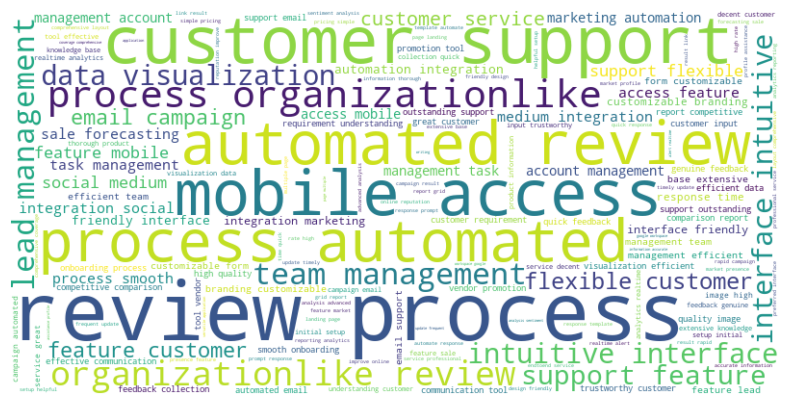

In [112]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Create a string with all features and their importance scores
feature_text = ' '.join([f"{feature['feature']} " * feature['importance'] for feature in all_top_features])

# Generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(feature_text)

# Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()
